In [28]:
pip install scikit-learn pandas


python(12381) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


##  Import Libraries

In [29]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

## Load Dataset

In [30]:


diabetes = load_diabetes(as_frame=True)
df = diabetes.frame
X = diabetes.data
y = diabetes.target

## EDA - Describe and Explore the Data

                age           sex           bmi            bp            s1  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean  -2.511817e-19  1.230790e-17 -2.245564e-16 -4.797570e-17 -1.381499e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02   
min   -1.072256e-01 -4.464164e-02 -9.027530e-02 -1.123988e-01 -1.267807e-01   
25%   -3.729927e-02 -4.464164e-02 -3.422907e-02 -3.665608e-02 -3.424784e-02   
50%    5.383060e-03 -4.464164e-02 -7.283766e-03 -5.670422e-03 -4.320866e-03   
75%    3.807591e-02  5.068012e-02  3.124802e-02  3.564379e-02  2.835801e-02   
max    1.107267e-01  5.068012e-02  1.705552e-01  1.320436e-01  1.539137e-01   

                 s2            s3            s4            s5            s6  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean   3.918434e-17 -5.777179e-18 -9.042540e-18  9.293722e-17  1.130318e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.

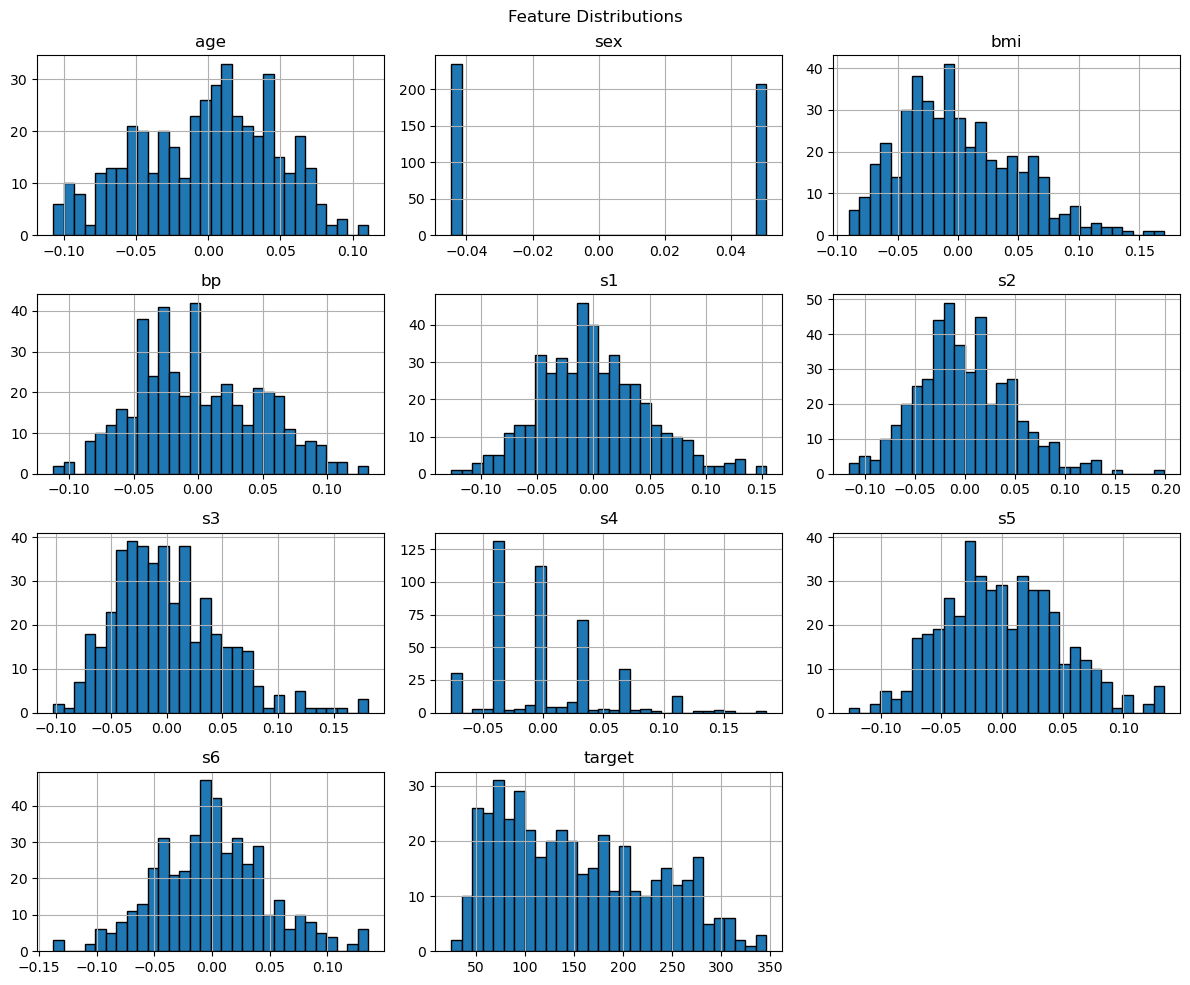

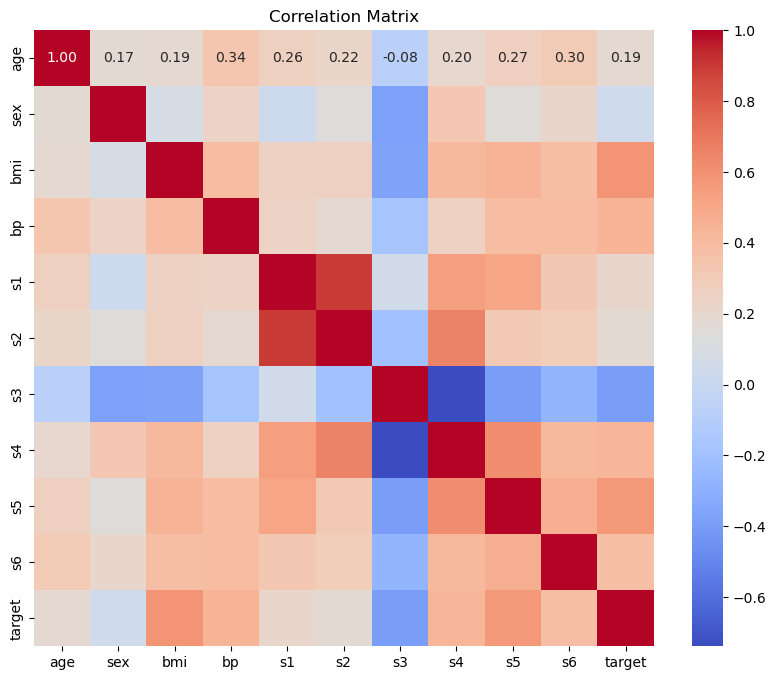

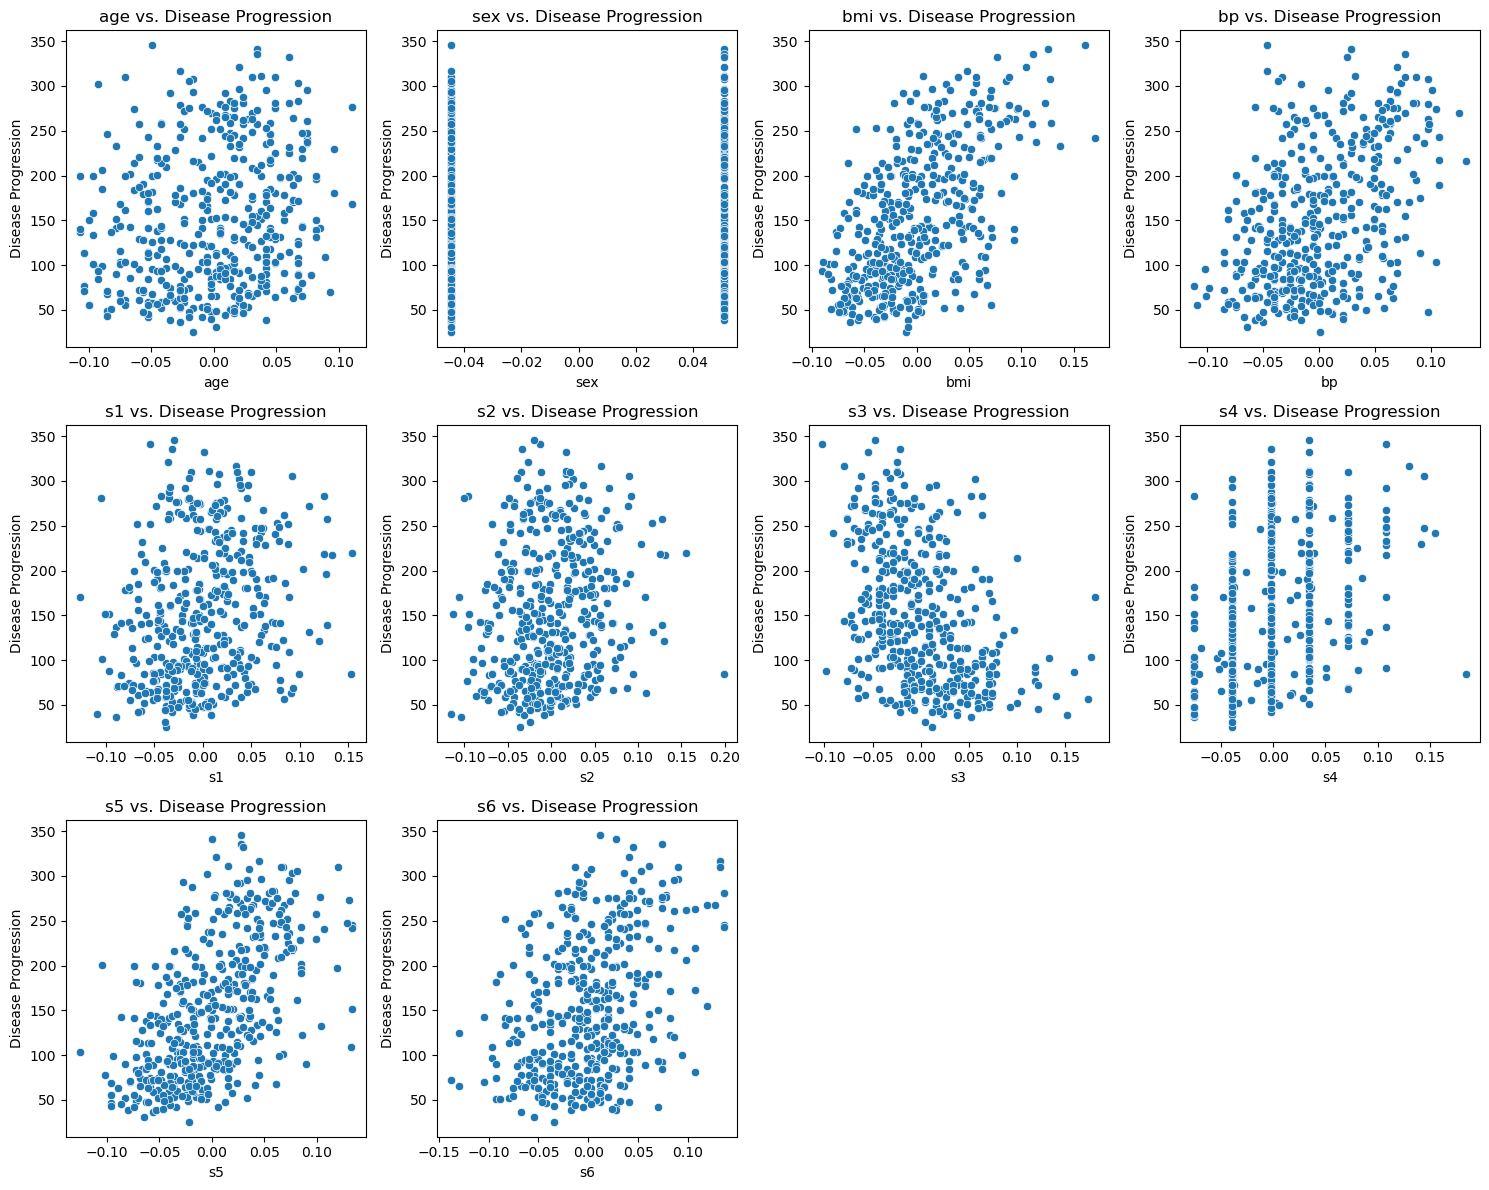

In [31]:


# Summary statistics
print(df.describe())

# Histogram of each feature
df.hist(bins=30, figsize=(12, 10), edgecolor='black')
plt.suptitle("Feature Distributions")
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


# Scatter plots of each feature vs. target
plt.figure(figsize=(15, 12)) # Adjusted figure size for better visibility
for i, col in enumerate(X.columns):
    plt.subplot(3, 4, i + 1) # 3 rows, 4 columns for 10 features + target
    sns.scatterplot(x=X[col], y=y)
    plt.title(f'{col} vs. Disease Progression')
    plt.xlabel(col)
    plt.ylabel('Disease Progression')
plt.tight_layout()
plt.show()


## Frame the Problem
### The goal is to Predict disease progression after one year using patient metrics

## Clean Data (no missing values)

In [32]:


print(df.isnull().sum())  # Confirm no nulls

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64


## STEP 6-  Train-Validation-Test Split

In [33]:

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)

## STEP 7 - Univariate Polynomial Regression 

In [34]:

results = []
X_train_bmi = X_train[['bmi']]
X_val_bmi = X_val[['bmi']]
X_test_bmi = X_test[['bmi']]

for degree in range(6):
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train_bmi)
    X_val_poly = poly.transform(X_val_bmi)
    model = LinearRegression().fit(X_train_poly, y_train)
    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)
    results.append({
        'Degree': degree,
        'Train R2': r2_score(y_train, y_train_pred),
        'Val R2': r2_score(y_val, y_val_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Train MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
        'Val MAPE': mean_absolute_percentage_error(y_val, y_val_pred)
    })

results_df = pd.DataFrame(results)
print(results_df)


   Degree  Train R2    Val R2  Train MAE    Val MAE  Train MAPE  Val MAPE
0       0  0.000000 -0.106957  66.201641  66.057059    0.628267  0.712639
1       1  0.349672  0.331264  52.287739  47.208472    0.483629  0.470600
2       2  0.350764  0.331631  52.207314  47.213700    0.482985  0.472397
3       3  0.350774  0.331638  52.198968  47.185414    0.482807  0.472227
4       4  0.353014  0.340758  52.092653  46.090118    0.480533  0.460503
5       5  0.354100  0.349881  52.059191  45.462121    0.480040  0.451753


## STEP 8- Best Model Identification

In [35]:

best_row = results_df.sort_values(by='Val R2', ascending=False).iloc[0]
best_degree = int(best_row['Degree'])
print(f"Best Degree: {best_degree}")

Best Degree: 5


## STEP 9- Evaluate on Test Set

In [36]:

poly_best = PolynomialFeatures(best_degree)
X_train_poly = poly_best.fit_transform(X_train_bmi)
X_test_poly = poly_best.transform(X_test_bmi)
model_best = LinearRegression().fit(X_train_poly, y_train)
y_test_pred = model_best.predict(X_test_poly)
print("Test R2:", r2_score(y_test, y_test_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, y_test_pred))

Test R2: 0.2666965844953081
Test MAE: 51.75025709277398
Test MAPE: 0.4302671323305443


## Step 10 - Polynomial degree

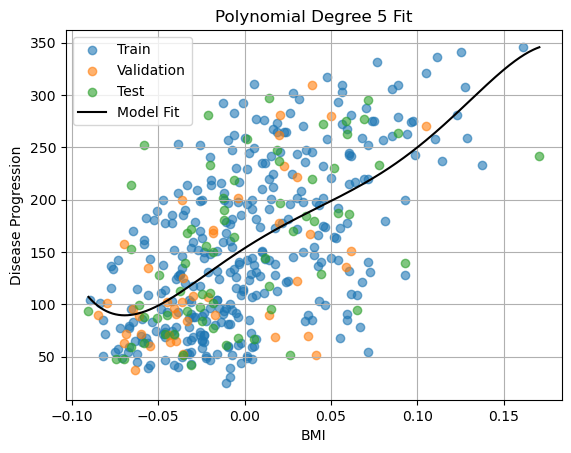

In [37]:
bmi_range = pd.DataFrame(np.linspace(X.bmi.min(), X.bmi.max(), 300), columns=['bmi'])
bmi_range_poly = poly_best.transform(bmi_range)
y_range_pred = model_best.predict(bmi_range_poly)
plt.scatter(X_train_bmi, y_train, label='Train', alpha=0.6)
plt.scatter(X_val_bmi, y_val, label='Validation', alpha=0.6)
plt.scatter(X_test_bmi, y_test, label='Test', alpha=0.6)
plt.plot(bmi_range, y_range_pred, color='black', label='Model Fit')
plt.legend()
plt.title(f'Polynomial Degree {best_degree} Fit')
plt.xlabel('BMI')
plt.ylabel('Disease Progression')
plt.grid(True)
plt.show()



## STEP 11- Model Equation

In [38]:

coefs = model_best.coef_
equation = " + ".join([f"{coefs[i]:.2f}*x^{i}" for i in range(len(coefs))])
print(f"Equation: y = {model_best.intercept_:.2f} + {equation}")

Equation: y = 153.65 + 0.00*x^0 + 1059.89*x^1 + -3824.15*x^2 + -16770.23*x^3 + 753722.52*x^4 + -2993716.57*x^5


## STEP 12- Predict for Sample BMI

In [39]:
import pandas as pd



sample_bmi = np.array([[0.03]])
sample_poly = poly_best.transform(sample_bmi)
print("Prediction for BMI=0.03:", model_best.predict(sample_poly)[0])





Prediction for BMI=0.03: 182.09454254518946


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


## STEP 13- Trainable Parameters

In [40]:

feature_names = poly_best.get_feature_names_out(['bmi'])
print("Features used by the polynomial model:", feature_names)
print("Total trainable parameters (including intercept):", len(feature_names) + 1)

Features used by the polynomial model: ['1' 'bmi' 'bmi^2' 'bmi^3' 'bmi^4' 'bmi^5']
Total trainable parameters (including intercept): 7


## multivariate polynomial model results

In [41]:

results_multi_poly = []

print("Evaluating Multivariate Polynomial Regression Models:")
for degree in [2, 3]:
    poly = PolynomialFeatures(degree=degree)
    X_train_poly_multi = poly.fit_transform(X_train)
    X_val_poly_multi = poly.transform(X_val)

    model = LinearRegression()
    model.fit(X_train_poly_multi, y_train)

    y_train_pred = model.predict(X_train_poly_multi)
    y_val_pred = model.predict(X_val_poly_multi)

    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100 

    r2_val = r2_score(y_val, y_val_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    mape_val = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100 

    results_multi_poly.append({
        'Model': f'Multivariate Polynomial Degree {degree}',
        'Train R-squared': r2_train,
        'Train MAE': mae_train,
        'Train MAPE': mape_train,
        'Validation R-squared': r2_val,
        'Validation MAE': mae_val,
        'Validation MAPE': mape_val
    })

results_multi_poly_df = pd.DataFrame(results_multi_poly)
print("\nMultivariate Polynomial Regression Results:")
print(results_multi_poly_df.round(4)) 

Evaluating Multivariate Polynomial Regression Models:

Multivariate Polynomial Regression Results:
                              Model  Train R-squared  Train MAE  Train MAPE  \
0  Multivariate Polynomial Degree 2          -1.2394    90.9184     78.2439   
1  Multivariate Polynomial Degree 3           0.6214    38.0725     32.3217   

   Validation R-squared  Validation MAE  Validation MAPE  
0               -1.6777         90.0682          95.4933  
1              -45.5406        244.9773         218.8036  


##  Decision Tree model results

In [42]:

results_dt = []

print("\nEvaluating Decision Tree Regression Models:")
for depth in [3, 5]:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42) 
    tree.fit(X_train, y_train)

    y_train_pred = tree.predict(X_train)
    y_val_pred = tree.predict(X_val)

    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

    r2_val = r2_score(y_val, y_val_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    mape_val = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100

    results_dt.append({
        'Model': f'Decision Tree Depth {depth}',
        'Train R-squared': r2_train,
        'Train MAE': mae_train,
        'Train MAPE': mape_train,
        'Validation R-squared': r2_val,
        'Validation MAE': mae_val,
        'Validation MAPE': mape_val
    })

results_dt_df = pd.DataFrame(results_dt)
print("\nDecision Tree Regression Results:")
print(results_dt_df.round(4)) 


Evaluating Decision Tree Regression Models:

Decision Tree Regression Results:
                   Model  Train R-squared  Train MAE  Train MAPE  \
0  Decision Tree Depth 3           0.5095    44.2599     38.8666   
1  Decision Tree Depth 5           0.6867    33.5270     29.9736   

   Validation R-squared  Validation MAE  Validation MAPE  
0                0.1983         48.1262          47.6729  
1                0.0939         49.6455          48.1620  


## kNN model results

In [43]:

results_knn = []

print("\nEvaluating k-Nearest Neighbors (kNN) Regression Models:")
for k in [3, 5]:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)

    y_train_pred = knn.predict(X_train)
    y_val_pred = knn.predict(X_val)

    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

    r2_val = r2_score(y_val, y_val_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    mape_val = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100

    results_knn.append({
        'Model': f'kNN (k={k})',
        'Train R-squared': r2_train,
        'Train MAE': mae_train,
        'Train MAPE': mape_train,
        'Validation R-squared': r2_val,
        'Validation MAE': mae_val,
        'Validation MAPE': mape_val
    })

results_knn_df = pd.DataFrame(results_knn)
print("\nk-Nearest Neighbors (kNN) Regression Results:")
print(results_knn_df.round(4)) 


Evaluating k-Nearest Neighbors (kNN) Regression Models:

k-Nearest Neighbors (kNN) Regression Results:
       Model  Train R-squared  Train MAE  Train MAPE  Validation R-squared  \
0  kNN (k=3)           0.6293    37.1380     31.5974                0.2142   
1  kNN (k=5)           0.5708    40.7734     34.9769                0.3585   

   Validation MAE  Validation MAPE  
0         45.7955          44.2421  
1         43.2909          41.2441  


## Evaluated the best univariate polynomial regression model on the test set

### Test R2: 0.2666965844953081
### Test MAE: 51.75025709277398
### Test MAPE: 0.4302671323305443








## Multivariate Models




| Model                          | Train R-squared | Train MAE | Train MAPE | Validation R-squared | Validation MAE | Validation MAPE |
|---------------------------------|-----------------|-----------|------------|----------------------|----------------|-----------------|
| Multivariate Polynomial Degree 2| -1.2394         | 90.9184   | 78.2439    | -1.6777              | 90.0682        | 95.4933         |
| Multivariate Polynomial Degree 3| 0.6214          | 38.0725   | 32.3217    | -45.5406             | 244.9773       | 218.8036        |
| Decision Tree Depth 3           | 0.5095          | 44.2599   | 38.8666    | 0.1983               | 48.1262        | 47.6729         |
| Decision Tree Depth 5           | 0.6867          | 33.5270   | 29.9736    | 0.0939               | 49.6455        | 48.1620         |
| kNN (k=3)                       | 0.6293          | 37.1380   | 31.5974    | 0.2142               | 45.7955        | 44.2421         |
| kNN (k=5)                       | 0.5708          | 40.7734   | 34.9769    | 0.3585               | 43.2909        | 41.2441         |


## Conclusion:

### The goal of this lab was to develop models that might forecast the course of diabetes. Using R-squared, MAE, and MAPE on train-validation-test splits, we assessed multivariate polynomial, Decision Tree, and k-Nearest Neighbours (kNN) models as well as univariate polynomial regression on BMI.

## Polynomial Regression in Univariate (on BMI)

### The Degree 5 Polynomial Regression on BMI was the greatest successful univariate model. It got an MAE of 51.75, a MAPE of 0.43, and a Test R-squared of about 0.27. Though it has a non-linear trend, its low R-squared reflects weak explanatory capability because the course of diabetes could not consistently predicted by BMI alone. The substantial dispersion around the model's fit was visually verified by the scatter plot.


## key observations: We found, 

### Multivariate Polynomial Models- Degrees 2 and 3 of both the multivariate polynomial models exhibited significant overfitting and numerical instabilities (negative R-squared) in validation, which resulted in very low accuracy. 

### Decision Trees: Validation R-squared declined from 0.1983 (Depth 3) to 0.0939 (Depth 5), suggesting overfitting as depth rose.

### kNN:Among all multivariate models, kNN (k=3) overfit (Val R2: 0.2142), while kNN (k=5) obtained the lowest validation errors (MAE 43.29, MAPE 41.24) and the best validation R-squared of 0.3585.

### In this experiment, al  ways th  at kNN (k=5) would instead be used by others, such a method has a better generalization with this dataset. However, validation R-squared of about 0.36 indicates that even that account only for a slight amount of variation in diabetes progression. It may mean interaction could be more complicated than current models can grasp or that the dataset misses some important features that can be used in the predicting process.



## Some of the steps that can improve are:
 ### For more reliable selection and optimization of models, feature engineering, considering more complex models such as Random Forests and Gradient Boosting, hyperparameter tuning, and combined cross-validation should be used to improve